In [ ]:
# %pip install numpy tifffile matplotlib scipy

In [130]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.stats import trim_mean

In [3]:
data = tifffile.imread('data/cropped_bottom_neuron_2000frames.tif')
data.shape

(2000, 11, 15)

# **Multi-Pixel Data Extraction to 1D Calcium Trace**  

In this unit, we focus on a common task in calcium imaging: converting multi-pixel fluorescence data from a single neuron into a single 1D trace over time. While each image frame may contain dozens or hundreds of pixels representing a cell, our goal is to summarize this data into a trace that reflects the neuron’s activity. This is a foundational step in calcium imaging analysis, and sets the stage for event detection, deconvolution, and time-series modeling. The sections below walk through each step—starting from pixel selection and ending with signal aggregation using both simple and robust methods.

## **Section 1: Identifying Active Pixels Using Thresholding**  

To generate a meaningful 1D trace from an image, the first step is to determine which pixels represent the cell’s signal. This involves thresholding fluorescence values to distinguish cell-related activity from background noise. Even in a single-cell image, signal intensity may vary due to inhomogeneous dye uptake, photobleaching, or imaging artifacts. Thresholding helps isolate the most relevant parts of the cell, so that downstream analysis is based on pixels that contribute meaningful information. This section introduces both global and adaptive thresholding techniques, and includes ways to visualize and validate the selected pixels.

**Sub-sections:**

1. **Compute Mean or Maximum Intensity Projection Over Time**  
   Create a projection image that summarizes activity across time. This projection is used to identify bright, active pixels that are likely to belong to the cell.  
   *Supports the overarching goal by defining candidate signal pixels for trace extraction.*

2. **Global Thresholding Based on Intensity or Percentiles**  
   Apply a fixed threshold or percentile-based cutoff to the projection image to select pixels. Visualization of the binary mask overlaid on the cell can help verify selection.  
   *Provides a fast and interpretable method for selecting signal-rich pixels.*

3. **Adaptive Thresholding Using Local Image Statistics**  
   Adjust thresholds dynamically based on local intensity statistics. This is useful when the cell signal is uneven or when illumination is not uniform.  
   *Improves robustness of pixel selection under non-uniform signal conditions.*

4. **Generate Binary Mask of Selected Pixels**  
   Convert the selected pixels into a binary mask that will be used for indexing the cell's pixels in the image stack.  
   *Provides a reusable data structure for downstream indexing and trace computation.*

A common first step in working with calcium imaging data is to reduce the 3D data (height × width × time) into a single 2D image. This projection summarizes activity across the entire session, helping us decide which parts of the image are relevant for further analysis. We begin by loading the actual calcium imaging data from a .tif file. This image contains 2000 frames of a single neuron. Our goal here is to reduce the 3D data (height × width × time) to a single image that summarizes cell activity across time.

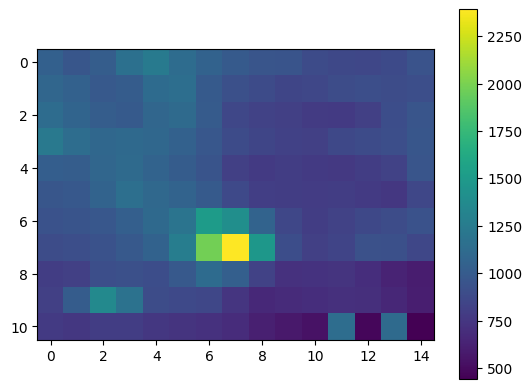

In [4]:
data = tifffile.imread('data/cropped_bottom_neuron_100frames.tif')
mean_projection = np.mean(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

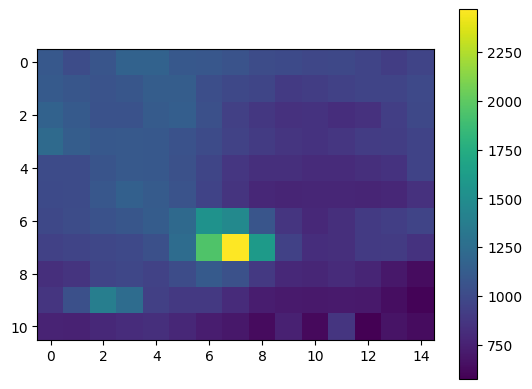

In [5]:
data = tifffile.imread('data/cropped_bottom_neuron_500frames.tif')
mean_projection = np.mean(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

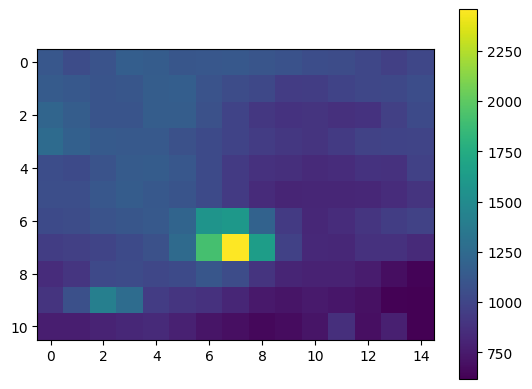

In [6]:
data = tifffile.imread('data/cropped_bottom_neuron_2000frames.tif')
mean_projection = np.mean(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

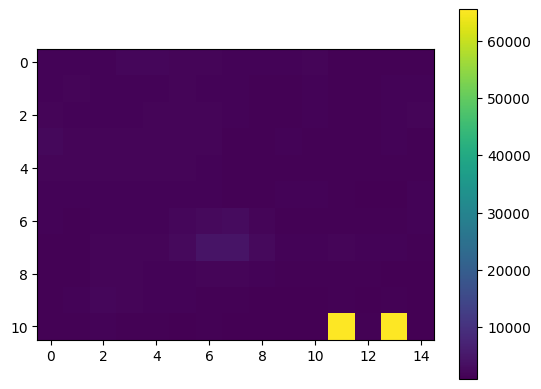

In [7]:
data = tifffile.imread('data/cropped_bottom_neuron_100frames.tif')
mean_projection = np.max(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

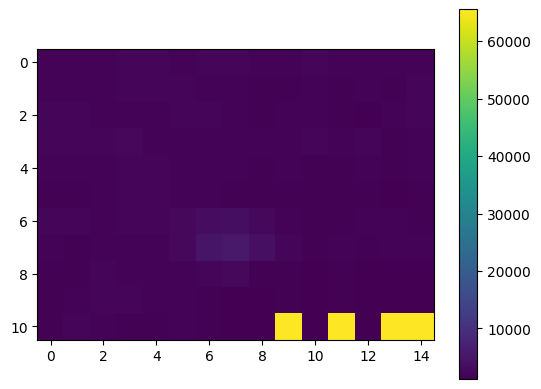

In [8]:
data = tifffile.imread('data/cropped_bottom_neuron_500frames.tif')
mean_projection = np.max(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

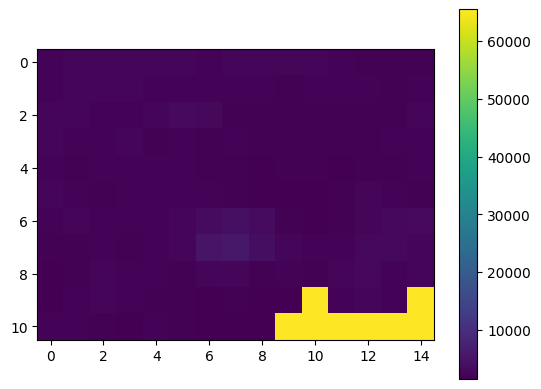

In [9]:
data = tifffile.imread('data/cropped_bottom_neuron_2000frames.tif')
mean_projection = np.max(data, axis=0)
plt.imshow(mean_projection)
plt.colorbar()

Once we have a projection, the next step is to isolate regions of interest by applying a global threshold. This defines which pixels are considered "active" or "signal-rich" and will be included in downstream processing.

**Exercise** Threshold the mean projection using an absolute cutoff 100

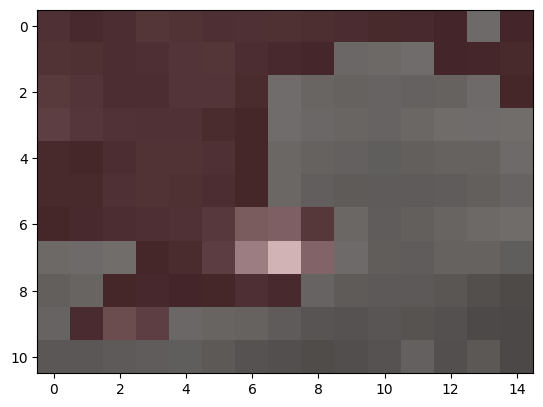

In [25]:
mean_projection = np.mean(data, axis=0)
mask_abs = mean_projection > 1000
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_abs, cmap='Reds', alpha=0.3)

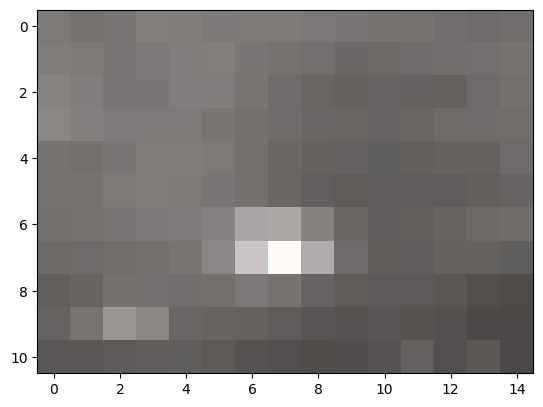

In [26]:
mean_projection = np.mean(data, axis=0)
mask_abs = mean_projection > 100
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_abs, cmap='Reds', alpha=0.3)

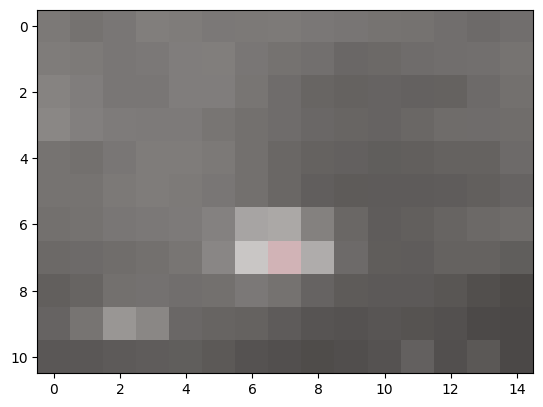

In [27]:
mean_projection = np.mean(data, axis=0)
mask_abs = mean_projection > 2000
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_abs, cmap='Reds', alpha=0.3)

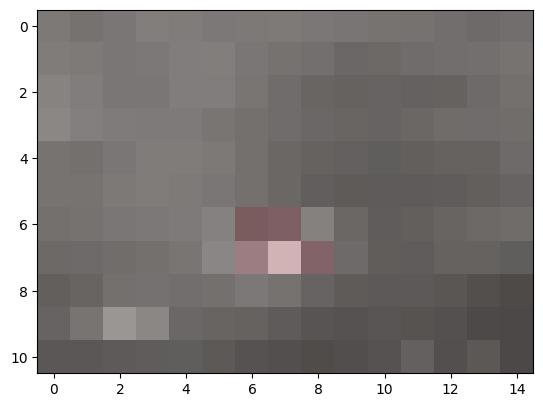

In [28]:
mean_projection = np.mean(data, axis=0)
mask_abs = mean_projection > 1500
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_abs, cmap='Reds', alpha=0.3)

**Exercise** Apply percentile-based threshold

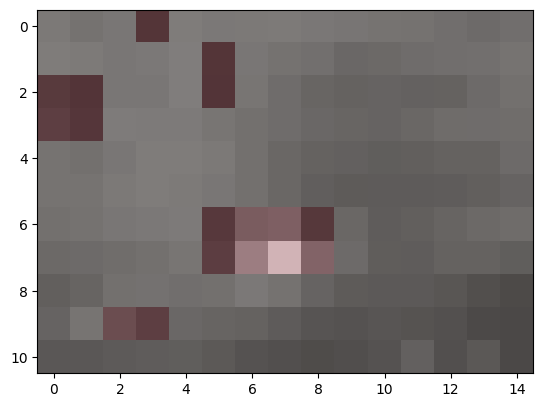

In [30]:
threshold_val = np.percentile(mean_projection, 90)
mask_percentile = mean_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_percentile, cmap='Reds', alpha=0.3)

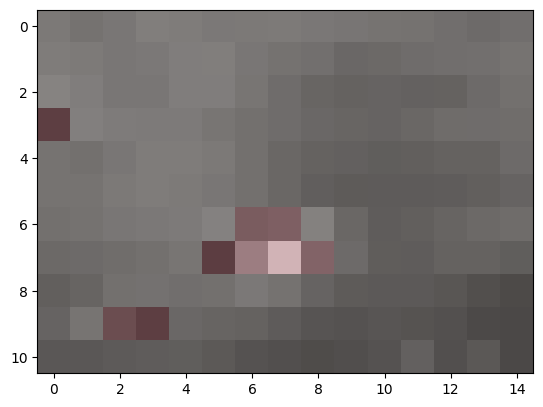

In [31]:
threshold_val = np.percentile(mean_projection, 95)
mask_percentile = mean_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_percentile, cmap='Reds', alpha=0.3)

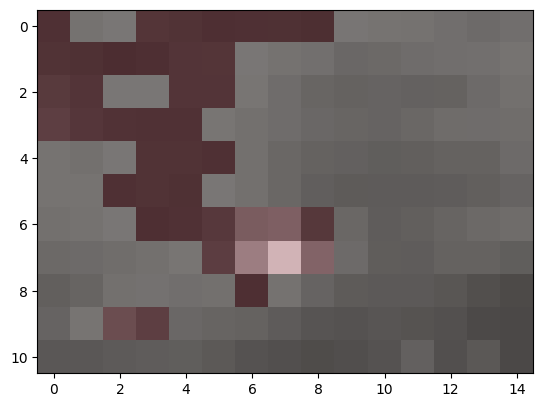

In [32]:
threshold_val = np.percentile(mean_projection, 75)
mask_percentile = mean_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_percentile, cmap='Reds', alpha=0.3)

Global thresholds may not capture cells well when the image has spatial variation. Adaptive thresholding uses local context to determine whether a pixel is bright relative to its neighborhood.

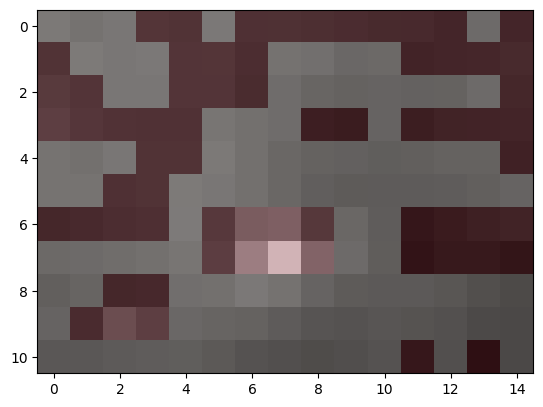

In [66]:
local_mean = uniform_filter(mean_projection, size=5)
mask_adaptive = mean_projection > local_mean
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_adaptive, cmap='Reds', alpha=0.3)

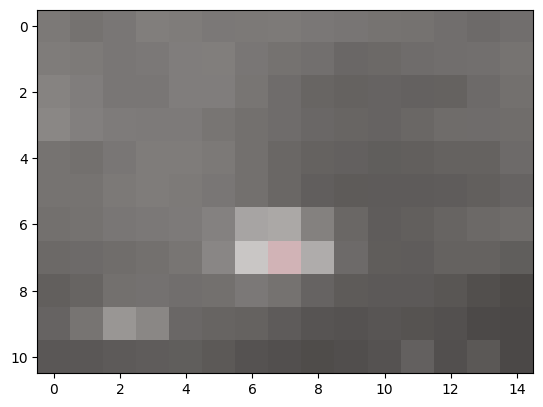

In [71]:
local_mean = uniform_filter(mean_projection, size=5)
mask_adaptive = mean_projection > 2*local_mean
plt.imshow(mean_projection, cmap='gray')
plt.imshow(mask_adaptive, cmap='Reds', alpha=0.3)

In [72]:
mean_projection = np.mean(data, axis=0)
mask_abs = mean_projection > 1500
mask = mask_abs.astype(bool)

In [73]:
np.sum(mask)

np.int64(5)

## **Section 2: Extracting Pixel Time Series Using Fancy Indexing**  

Once the relevant pixels have been identified, the next step is to extract their fluorescence values across all time frames. Since cells often have irregular shapes, their pixels are not arranged in a rectangular block. This requires the use of advanced indexing techniques to selectively access those pixel values. In this section, we demonstrate how to use `numpy`'s fancy indexing to extract pixel-wise time series from a 3D calcium imaging dataset. The result is a 2D matrix where each row corresponds to a pixel and each column to a time point—an essential structure for averaging.

**Sub-sections:**

1. **Extract (x, y) Coordinates from Binary Mask**  
   Use logical operations to extract the spatial coordinates of all pixels marked as active in the binary mask.  
   *Defines the pixel positions to extract fluorescence values from.*

2. **Apply Fancy Indexing to Extract Fluorescence Traces**  
   Use the extracted coordinates to gather time-series data from the original imaging stack.  
   *Retrieves relevant pixel data across all time frames.*

3. **Stack or Reshape ROI Pixel Data for Analysis**  
   Organize the extracted data into a consistent shape (pixels × time) to enable averaging or further processing.  
   *Prepares the data for aggregation into a 1D trace.*

**Exercise** Extract (x,y) co-ordinates of the active pixels

In [74]:
y_coords, x_coords = np.nonzero(mask)
coords = list(zip(x_coords, y_coords))
coords

[(np.int64(6), np.int64(6)),
 (np.int64(7), np.int64(6)),
 (np.int64(6), np.int64(7)),
 (np.int64(7), np.int64(7)),
 (np.int64(8), np.int64(7))]

**Exercise** Use the (x, y) pixel coordinates to extract fluorescence values across time.

In [81]:
data.shape

(2000, 11, 15)

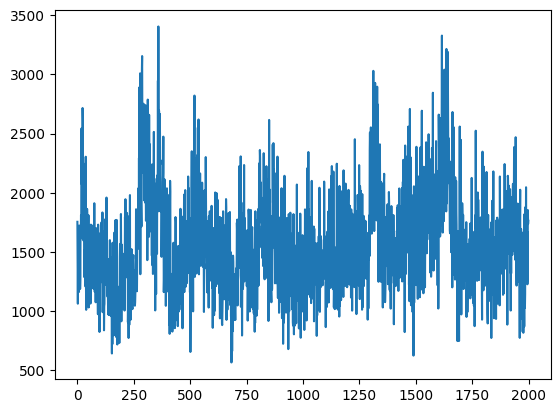

In [78]:
x, y = coords[0]
plt.plot(data[:, y, x])


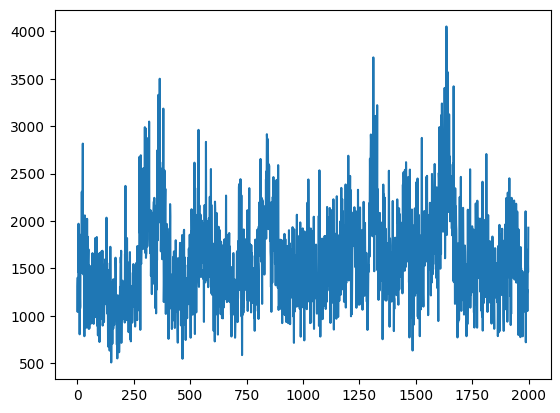

In [85]:
x, y = coords[1]
plt.plot(data[:, y, x])


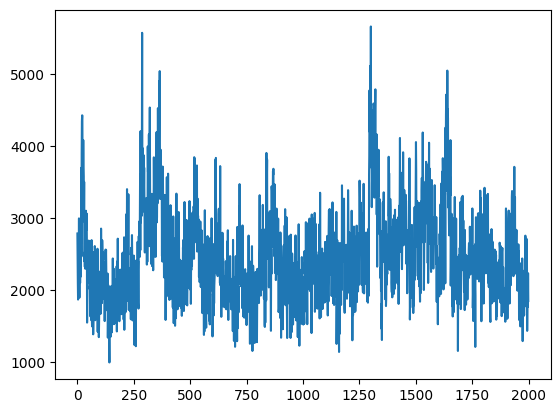

In [86]:
x, y = coords[3]
plt.plot(data[:, y, x])

In [96]:
traces = np.array([data[:, y, x] for (x,y) in coords])
traces.shape

(5, 2000)

## **Section 3: Averaging Pixel Values to Create a 1D Trace**  

With the pixel-wise fluorescence time series in hand, we now reduce this information to a single trace that summarizes the cell's activity. This is commonly done by averaging the fluorescence across all pixels in the ROI at each time point. This section shows how to compute and visualize a mean trace using `numpy`, and also discusses when it might be preferable to use the median instead of the mean. The goal is to obtain a 1D time series that is representative, interpretable, and suitable for downstream analyses.

**Sub-sections:**

1. **Compute and Visualize Mean Calcium Trace Over Time**  
   Aggregate the pixel values using `np.mean()` and plot the result to inspect the trace.  
   *This operation directly produces the single calcium trace representing the neuron.*

2. **Compare Mean and Median Averaging**  
   Evaluate how the trace differs when using the mean versus the median, especially in noisy data.  
   *Provides insight into the stability and robustness of different aggregation methods.*

3. **Optional Normalization or Scaling for Trace Comparison**  
   Normalize the resulting trace for visualization or comparison across cells.  
   *Facilitates clearer interpretation, especially when examining multiple traces.*

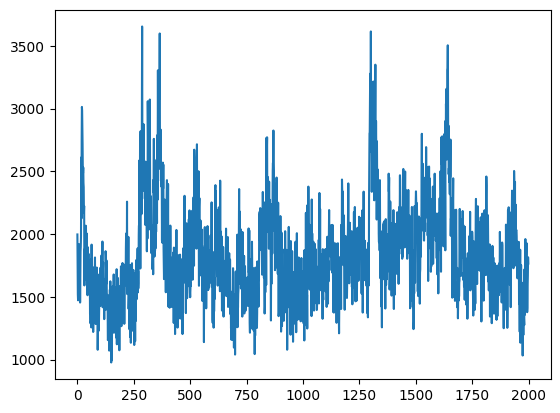

In [97]:
mean_trace = np.mean(traces, axis=0)
plt.plot(mean_trace)

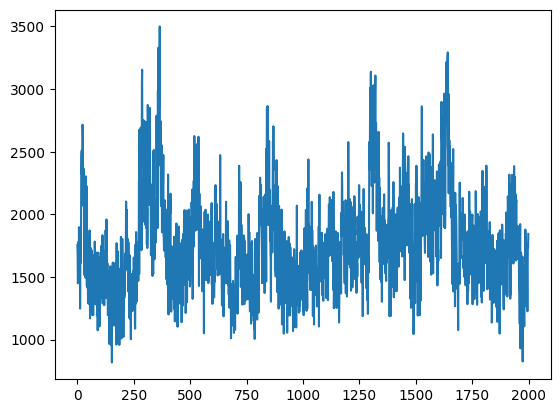

In [99]:
median_trace = np.median(traces, axis=0)
plt.plot(median_trace)

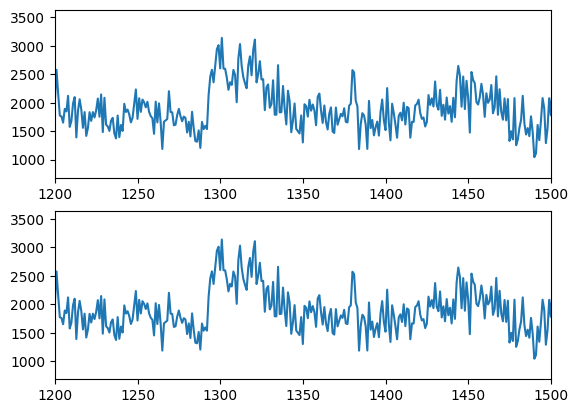

In [103]:
ax1 = plt.subplot(211)
plt.plot(mean_trace)
plt.xlim(1200, 1500)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(median_trace)

## **Section 4: Using Weighted and Robust Aggregation Methods**  

While averaging is often sufficient, not all pixels in the ROI may contribute equally to the signal. Some may be on the edge, poorly illuminated, or contain more noise. Weighted and non-parametric aggregation methods can improve the quality of the final trace by accounting for pixel-level differences. In this section, we introduce weighted averaging using `numpy`, and robust methods such as the median or trimmed mean using `scipy.stats`. These techniques help produce cleaner and more biologically realistic traces, particularly in cases with signal heterogeneity.

**Sub-sections:**

1. **Assign Weights Based on Pixel Brightness or Proximity**  
   Create a set of pixel-wise weights based on average intensity or spatial location.  
   *Enables control over which pixels influence the trace more.*

2. **Compute Weighted Mean with `np.average()`**  
   Apply weighted averaging across pixels to generate a time series.  
   *Improves trace quality in unevenly segmented or noisy ROIs.*

3. **Use Robust Aggregation: Median or Trimmed Mean**  
   Use non-parametric functions like `np.median()` or `scipy.stats.trim_mean()` to reduce the impact of outliers.  
   *Provides alternatives when pixel contributions vary or noise is prominent.*

Assign weights 

**Exercise** Mean fluorescece of each active pixel

In [107]:
np.mean(traces[0])

np.float64(1570.365)

In [108]:
np.mean(traces[1])

np.float64(1597.147)

In [109]:
np.mean(traces[2])

np.float64(1916.9315)

In [110]:
np.mean(traces[3])

np.float64(2456.469)

In [111]:
np.mean(traces[4])

np.float64(1640.6885)

In [112]:
np.mean(traces, axis=1)

array([1570.365 , 1597.147 , 1916.9315, 2456.469 , 1640.6885])

**Exercise** We can use normalized pixel means as weights

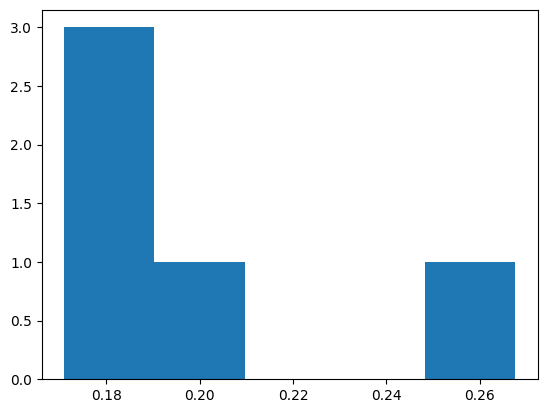

In [125]:
active_pixel_means = np.mean(traces, axis=1)
weights = active_pixel_means / np.sum(active_pixel_means)
plt.hist(weights, bins=5);

Compute weighted average

**Exercise** compute weighted average

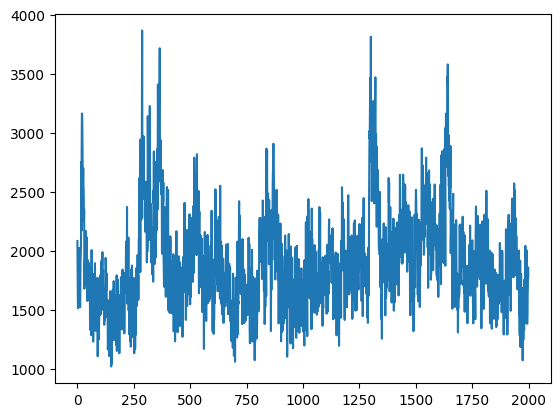

In [128]:
active_pixel_means = np.mean(traces, axis=1)
weights = active_pixel_means / np.sum(active_pixel_means)

weighted_trace = np.average(traces, axis=0, weights=weights)
plt.plot(weighted_trace)

Robust aggregation

**Exercise** Compute trimmed mean

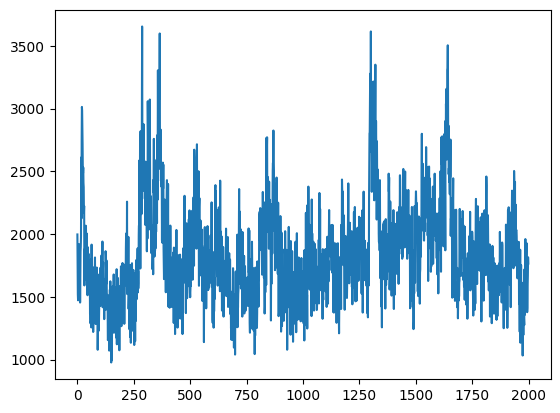

In [131]:
trimmed_trace = trim_mean(traces, proportiontocut=0.1, axis=0)
plt.plot(trimmed_trace)